In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import os
import random
import numpy as np
import nibabel as nib
from scipy import ndimage
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
print ("nums GPU",len(tf.config.list_physical_devices('GPU')))

nums GPU 1


In [3]:
SEED=123456
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC']='1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [4]:
def remove_store(base_path, files):
    new_files = []
    for j in files:
        b_path = os.path.join(base_path, j)
        if(os.path.isdir(b_path)):
            new_files.append(b_path)
    return new_files

In [5]:
def get_data(tumor='LGG', pattern='t1'):
    # Get patient folders
    base_path = os.path.join('..', 'data', tumor)    
    patients = os.listdir(base_path)
    p2 = remove_store(base_path, patients)
    #print(p2)
    #print(patients)
    urls = []
    for i in p2:
        # Get files for each patient
        # patient_path = os.path.join(base_path, i)
        files = [v for v in os.listdir(i) if v != '.DS_Store']
        #print(files)        
        for j in files:
            # m = re.match(r"^(?!.*(t2|flair|seg)).*", j)
            m = pattern in j
            if m:
                urls.append(os.path.join(i, j))                
    if(pattern == 't1'):
        new_urls = [v for v in urls if 't1ce' not in v]
    else:
        new_urls = urls
    return new_urls

In [6]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

In [7]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 32 # SLICES
    desired_width = 64
    desired_height = 64
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(
        img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [8]:
def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [9]:
low_grade_paths = get_data(tumor='LGG', pattern='flair')
high_grade_paths = get_data(tumor='HGG', pattern='flair')

In [10]:
high_grade_paths

['..\\data\\HGG\\BraTS20_Training_001\\BraTS20_Training_001_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_002\\BraTS20_Training_002_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_003\\BraTS20_Training_003_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_004\\BraTS20_Training_004_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_005\\BraTS20_Training_005_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_006\\BraTS20_Training_006_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_007\\BraTS20_Training_007_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_008\\BraTS20_Training_008_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_009\\BraTS20_Training_009_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_010\\BraTS20_Training_010_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_011\\BraTS20_Training_011_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_012\\BraTS20_Training_012_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_013\\BraTS20_Training_013_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_

In [11]:
low_grade_scans = np.array([process_scan(path) for path in low_grade_paths])
high_grade_scans = np.array([process_scan(path) for path in high_grade_paths])

In [12]:
low_grade_scans[0].shape

(64, 64, 32)

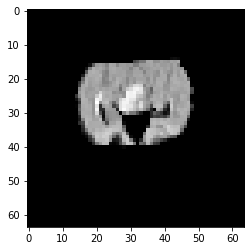

In [13]:
plt.imshow(low_grade_scans[0][:,:,10], cmap=mpl.cm.gray)

In [14]:
low_grade_labels = np.array([1 for _ in range(len(low_grade_scans))])
high_grade_labels = np.array([0 for _ in range(len(high_grade_scans))])

In [15]:
x_train = np.concatenate((low_grade_scans[:50], high_grade_scans[:200]), axis=0)
y_train = np.concatenate((low_grade_labels[:50], high_grade_labels[:200]), axis=0)
x_test = np.concatenate((low_grade_scans[50:], high_grade_scans[200:]), axis=0)
y_test = np.concatenate((low_grade_labels[50:], high_grade_labels[200:]), axis=0)

In [16]:
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [17]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [18]:
batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [19]:
assert x_train.shape == (250, 64, 64, 32)
assert x_test.shape == (118,  64, 64, 32)
assert y_train.shape == (250,)
assert y_test.shape == (118,)

plt.figure(figsize=(9,9))
rndSamples=np.random.choice(60000,9)
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(x_train[rndSamples[i]], cmap="Greys_r")
    plt.axis('off')
    plt.show();

In [20]:
dataset = np.concatenate([x_train, x_test], axis=0)
dataset = np.expand_dims(dataset, -1).astype("float32") / 255
print(dataset.shape)

(368, 64, 64, 32, 1)


In [21]:


class SamplingLayer(layers.Layer):
#REPARAMETRIZATION TRICK Z=MU+SIGMA*EPSILON
    def call(self, inputs):
        zMean,zLogVar=inputs
        batch=tf.shape(zMean)[0]
        dim=tf.shape(zMean)[1]
        epsilon=tf.keras.backend.random_normal(shape=(batch,dim))
        return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [22]:
def buildEncoder(latentDim, encoderInputs):  
    
    l1 = keras.models.Sequential([
        layers.Conv3D(128, 3, activation="relu", strides=2, padding="same"),
        layers.Conv3D(64, 3, activation="relu", strides=2, padding="same"),
        layers.Flatten(),
        layers.Dense(256, activation="relu")        
    ])
    
    x = l1(encoderInputs)
    
    zMean = layers.Dense(latentDim, name="z_mean")(x)
    
    zLogVar = layers.Dense(latentDim,name="z_log_var")(x)
    
    z =  SamplingLayer()([zMean, zLogVar])
    
    return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")

encoderInputs = keras.Input(shape=(64, 64, 32, 1))
encoder = buildEncoder(3,encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 32,  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256)          33779520    input_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            771         sequential[0][0]                 
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 3)            771         sequential[0][0]                 
____________________________________________________________________________________________

In [23]:
def buildDecoder(latentInputs):
    l1 = keras.models.Sequential([
        layers.Dense(16*16*8*32, activation="relu", input_shape=(latentInputs.shape[1],)),
        layers.Reshape((16,16,8,32)),
        layers.Conv3DTranspose(filters=128, kernel_size=3, activation="relu", strides=2, padding="same"),
        layers.Conv3DTranspose(filters=64, kernel_size=3, activation="relu", strides=2, padding="same"),
        layers.Conv3DTranspose(filters=1, kernel_size=3, activation="sigmoid", padding="same")     
    ])
    
    return keras.Model(latentInputs, l1(latentInputs), name="decoder")

latentInputs = keras.Input(shape=(3,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 32, 1)     595841    
Total params: 595,841
Trainable params: 595,841
Non-trainable params: 0
_________________________________________________________________


In [24]:
def reconstructionLoss(data, reconstructed):
    return tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(data, reconstructed),
            axis=(1,2)
        )
    )

In [25]:
def klDivergenceLoss(zMean, zLogVar):
    return tf.reduce_mean(
        tf.reduce_sum(
            -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
            axis=1
        )
    )

In [26]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
    loss1 = reconstructionLoss(data, reconstructed)
    loss2 = klDivergenceLoss(zMean,zLogVar)
    klWeight = 3.0
    return loss1, loss2, loss1 + klWeight * loss2
    

In [27]:
class VAE(keras.Model):    
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder=encoder
        self.decoder=decoder

        self.totalLossTracker= keras.metrics.Mean(name="total_loss")
        self.ceLossTracker= keras.metrics.Mean(name="ce_loss")
        self.klLossTracker= keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return[
            self.totalLossTracker,
            self.ceLossTracker,
            self.klLossTracker            
        ]
    
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            zMean, zLogVar, z = self.encoder(data)
            reconstruction = self.decoder(z)
            ceLoss, klLoss, totalLoss = calcTotalLoss(data,reconstruction,zMean,zLogVar)

        grads = tape.gradient(totalLoss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.totalLossTracker.update_state(totalLoss)
        self.ceLossTracker.update_state(ceLoss)
        self.klLossTracker.update_state(klLoss)
        
        return{
            "total_loss": self.totalLossTracker.result(),
            "ce_loss": self.ceLossTracker.result(),
            "kl_loss": self.klLossTracker.result()      
        }

In [28]:
vae=VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001))
history=vae.fit(dataset,epochs=20,batch_size=3)
print(dataset.shape)

Epoch 1/20
123/123 [==============================] - 49s 377ms/step - total_loss: 2838.2554 - ce_loss: 2837.7952 - kl_loss: 0.1535
Epoch 2/20
123/123 [==============================] - 47s 380ms/step - total_loss: 2832.2061 - ce_loss: 2831.8687 - kl_loss: 0.1127
Epoch 3/20
123/123 [==============================] - 47s 382ms/step - total_loss: 2822.0933 - ce_loss: 2820.8364 - kl_loss: 0.4190
Epoch 4/20
123/123 [==============================] - 47s 384ms/step - total_loss: 2797.7515 - ce_loss: 2796.7305 - kl_loss: 0.3406
Epoch 5/20
123/123 [==============================] - 47s 385ms/step - total_loss: 2671.3647 - ce_loss: 2624.3589 - kl_loss: 15.6688
Epoch 6/20
123/123 [==============================] - 48s 389ms/step - total_loss: 2010.2247 - ce_loss: 1833.7495 - kl_loss: 58.8252
Epoch 7/20
123/123 [==============================] - 49s 395ms/step - total_loss: 1313.7494 - ce_loss: 1172.2814 - kl_loss: 47.1562
Epoch 8/20
123/123 [==============================] - 49s 396ms/step - to

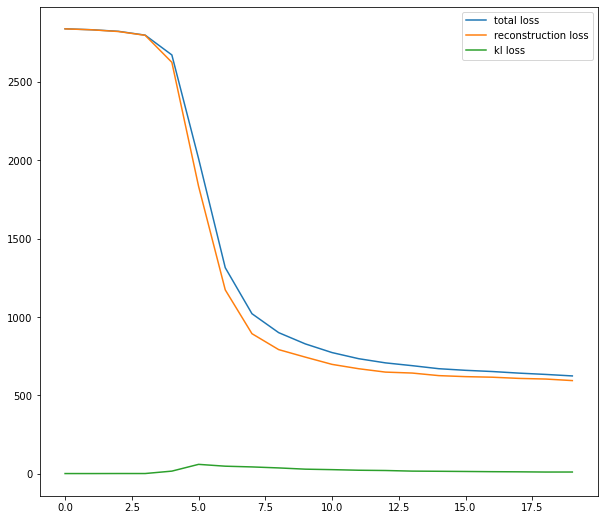

In [29]:
plt.figure(figsize=(10,9))
plt.plot(history.history.get("total_loss"), label= "total loss")
plt.plot(history.history.get("ce_loss"), label= "reconstruction loss")
plt.plot(history.history.get("kl_loss"), label= "kl loss")
plt.legend();

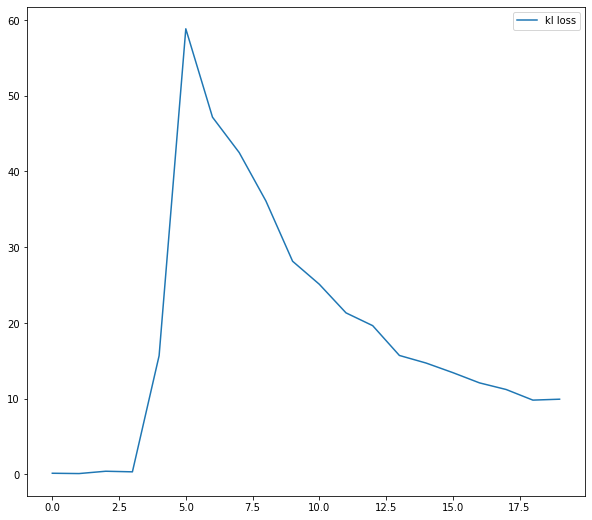

In [30]:
plt.figure(figsize=(10,9))
plt.plot(history.history.get("kl_loss"), label= "kl loss")
plt.legend();

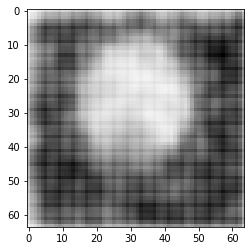

In [31]:
synth= vae.decoder.predict([[1, 2, 2]])
new_tumor=synth.reshape((64,64,32))
plt.imshow(new_tumor[:,:,10], cmap=mpl.cm.gray)


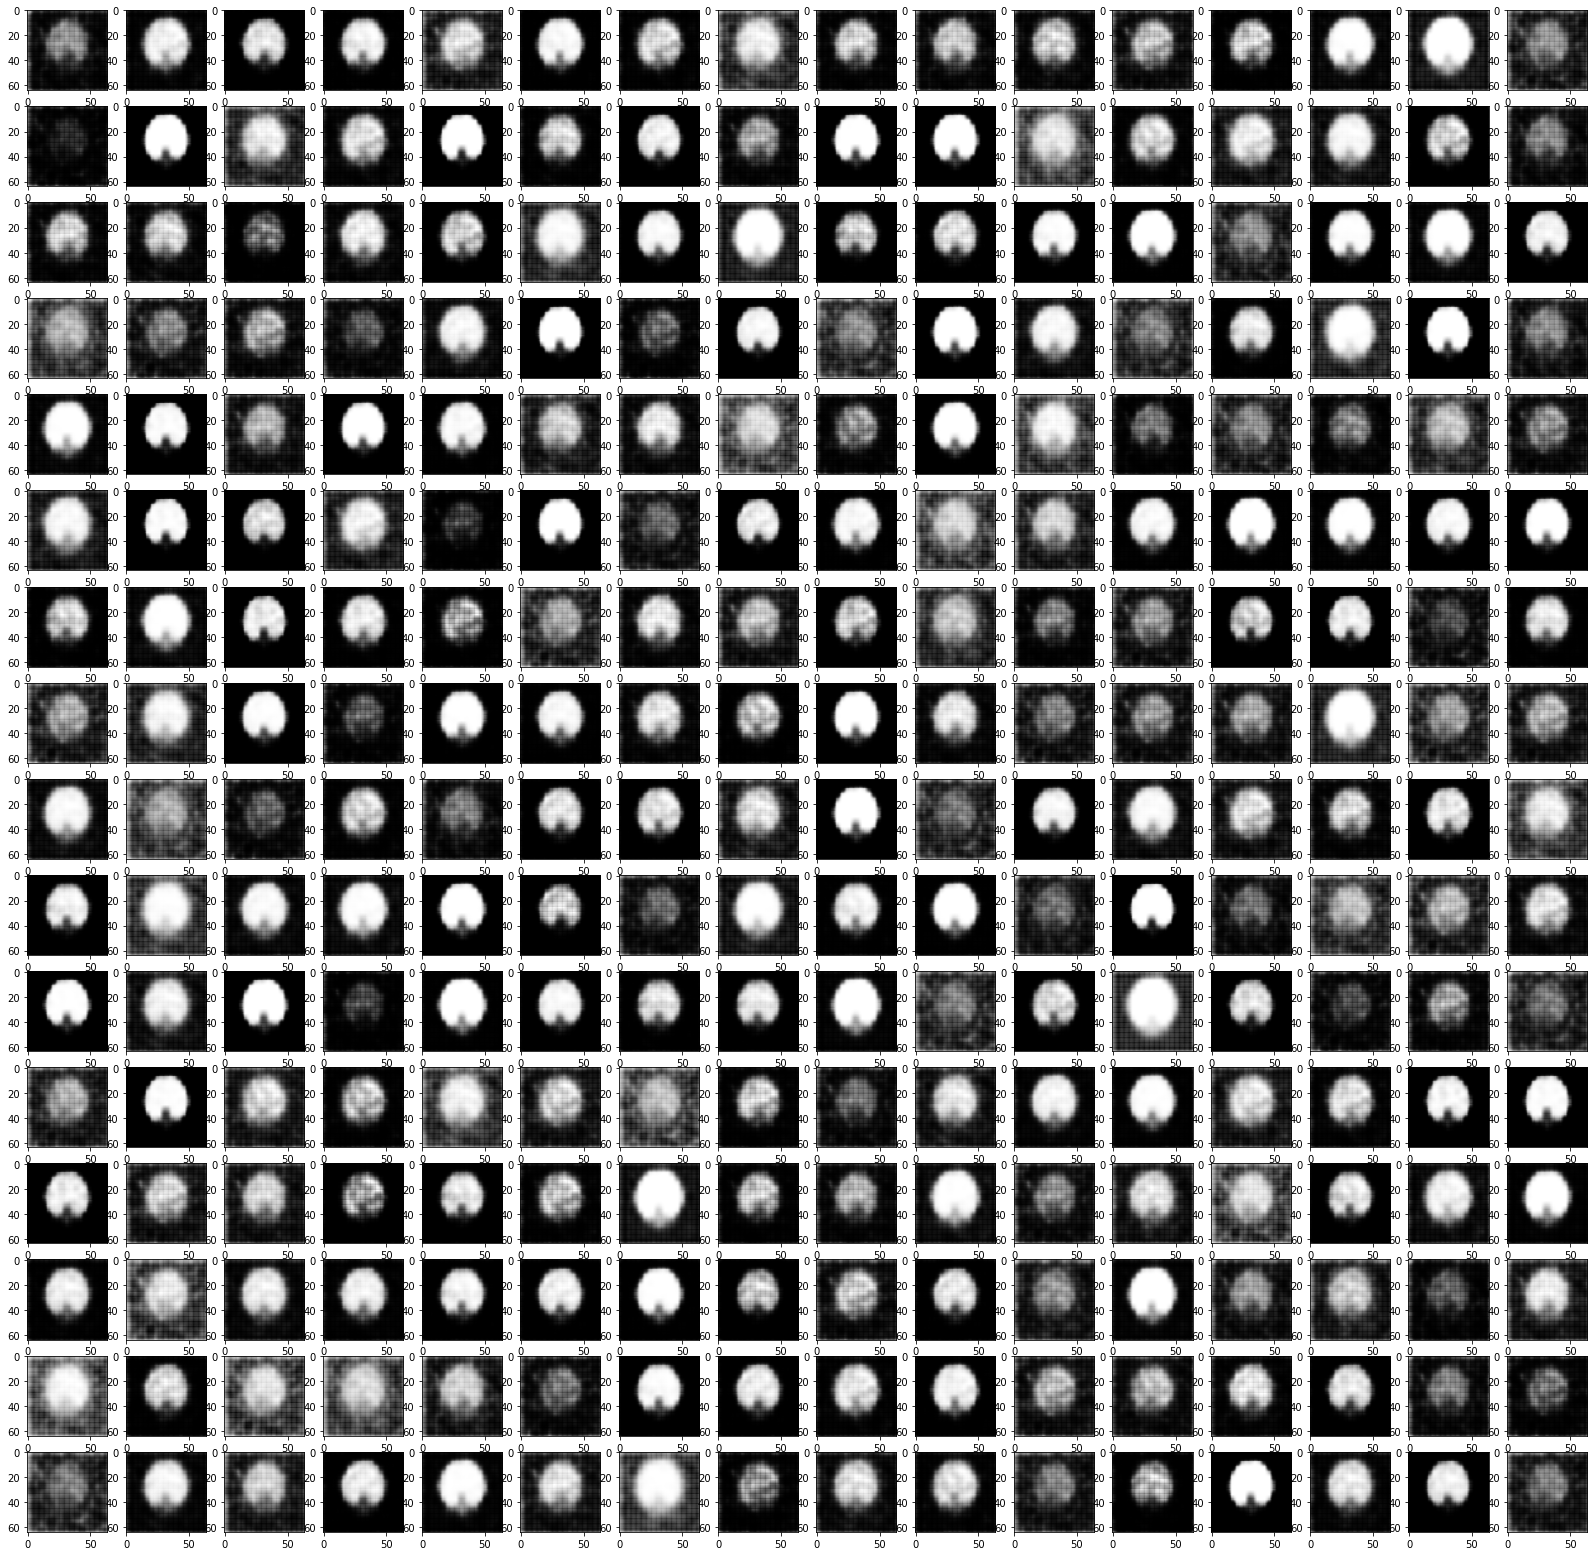

In [32]:
z = np.random.normal(loc=0, scale=4, size=(256,3))
synth= vae.decoder.predict(z)
plt.figure(figsize=(28,28))
for i in range(256):
    plt.subplot(16, 16, i+1)
    new_t=synth[i].reshape(64,64,32)
    plt.imshow(new_t[:,:,10], cmap=mpl.cm.gray)  
    

plt.show();

In [33]:
idx= 20
batch = np.expand_dims(x_train[idx], axis=0)
batchOfImages= np.expand_dims(batch, axis=-1).astype("float32")/255
print(batchOfImages.shape)

_ ,_ , z = vae.encoder.predict(batchOfImages)

synth = vae.decoder.predict([z])

z

(1, 64, 64, 32, 1)


array([[ 2.570046 , -1.8704324, -1.5813303]], dtype=float32)

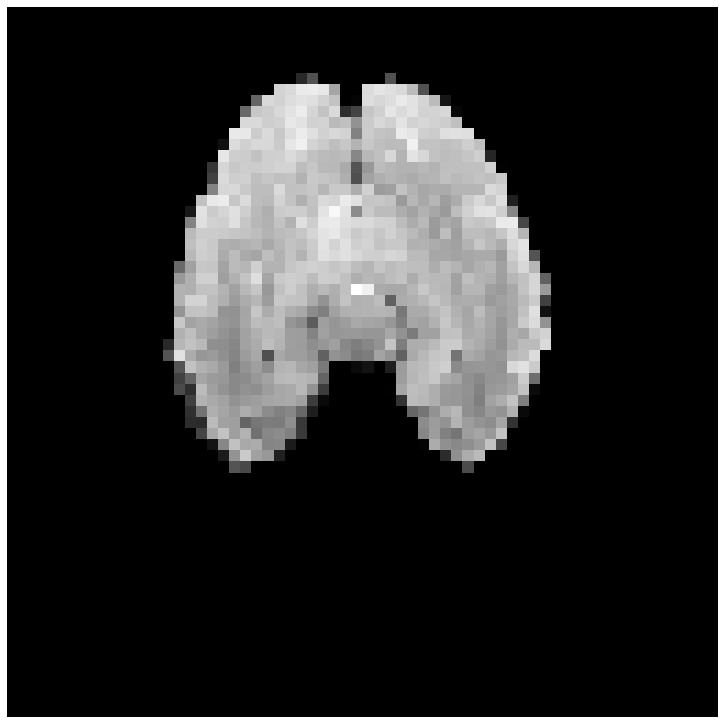

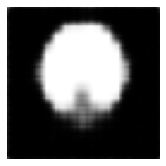

In [34]:
plt.figure(figsize=(28,28))
 # ORIGINAL
plt.subplot(1,2,1)
plt.axis('off')
tumor_o=x_train[idx]
plt.imshow(tumor_o[:,:,10], cmap=mpl.cm.gray)  
plt.show();

# RECONSTRUCTED

plt.subplot(1,2,2)
plt.axis('off')
new_t=synth[0].reshape(64,64,32)
plt.imshow(new_t[:,:,10], cmap=mpl.cm.gray) 



AttributeError: module 'matplotlib.pyplot' has no attribute 'zlabel'

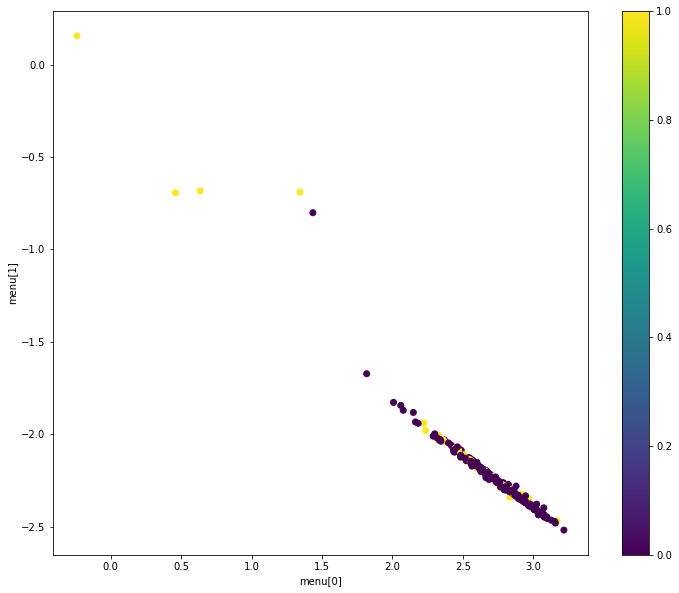

In [39]:
labels= np.concatenate([y_train, y_test], axis=0)
menu, _, _= vae.encoder.predict(dataset)
plt.figure(figsize=(12,10))
plt.scatter(menu[:,0], menu[:,1], c=labels)
plt.colorbar()
plt.xlabel("menu[0]")
plt.ylabel("menu[1]")
plt.zlabel("menu[2]")
plt.show();